C:\Users\Dr.lei\AppData\Local\Temp\ipykernel_4356\4043942589.py:47: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


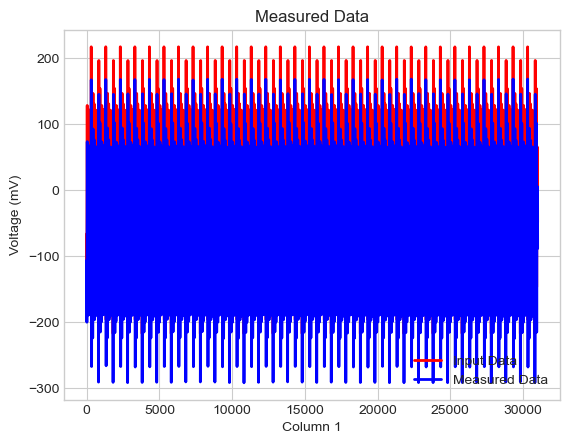

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Define the file name containing Chinese characters
file_name = u'../data/20230808/145C-noisy-unkonwn-data-5min'

timeDelay = 3 # ms

# Read the file and extract the data columns
data = np.loadtxt(file_name)
col1 = data[:, 0]
col2 = data[:, 1]


start_N = 0
start_num = 1005
MeasureNum =  31000

cropCol1 = col1[(start_num+timeDelay):(start_num+MeasureNum+timeDelay)]  # Measure
cropCol2 = col2[start_num:start_num+MeasureNum]  # Input

BInput = cropCol2 * 1000 #* 4.608 # V --> mV --> pT , mV
yMeasure = cropCol1 * 1000 # V --> mV
yMeasureCurrent = col1[start_num:start_num+MeasureNum] * 1000


# # Plot the input data
# plt.figure()
# plt.plot(BInput, linewidth=2, color='red', label='Input Data')
# plt.title('Input Data')
# plt.ylabel('Voltage (mV)')
# plt.legend(loc='lower right')
# plt.show()

# # Plot the measured data
# plt.figure()
# plt.style.use('seaborn-whitegrid')
# plt.plot(yMeasureCurrent, linewidth=2, color='blue', label='Measured Data')
# plt.title('Measured Data')
# plt.xlabel('Column 1')
# plt.ylabel('Voltage (mV)')
# plt.legend(loc='lower right')
# plt.show()

# Plot the measured data
plt.figure()
plt.style.use('seaborn-whitegrid')
plt.plot( 7.45818*BInput, linewidth=2, color='red', label='Input Data')
plt.plot(yMeasure, linewidth=2, color='blue', label='Measured Data')
plt.title('Measured Data')
plt.xlabel('Column 1')
plt.ylabel('Voltage (mV)')
plt.legend(loc='lower right')
plt.show()


In [64]:
col1.size

313890

In [65]:
from filterpy.kalman import KalmanFilter

#zPred = np.asarray(zPred).reshape(-1)
zRef = 7.45818 * BInput
Kscale = 7.45818

Qspn = 1.8824 # fT
coil_constant = 9.2393 #pT/mV

# Plot the predicted and reference curves
timeRange = np.array([1/1000 * i for i in range(len(BInput))])
Q1 = 0
Q2 = Qspn / coil_constant * 1e-3 * Kscale / 100   # uA
print('Q2 : ', Q2)
#Q2 = 11.2845*1e-5

GRpsn = 2.9306654534422725e-05 * 100 # mV
#GRpsn = 0.0286

tracker = KalmanFilter(dim_x=2, dim_z=1, dim_u=1)
dt = 1/1000   # time step 1 second

tracker.F = np.array([[0, 0],[Kscale / 100, 0]])

from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise

q = Q_discrete_white_noise(dim=2, dt=dt, var=0.01)
tracker.Q = np.array([[Q1**2, 0],[0, Q2**2]])
print(tracker.Q, q)
tracker.B = np.array([[1],[0]])

tracker.H = np.array([[0, 1e2]])

tracker.R = np.array([[GRpsn**2]])

tracker.x = np.array([[0],[0]])
tracker.P = np.eye(2) * 1.

mu, cov, _, _ = tracker.batch_filter(yMeasure, us=BInput)

mu0 = mu[:,0,:].reshape(-1)
mu1 = mu[:,1,:].reshape(-1)
KF_estimate_In = mu0 
KF_estimate_Measure = mu1 * 1e2

Q2 :  1.5195174993776583e-05
[[0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.30893343e-10]] [[2.5e-15 5.0e-12]
 [5.0e-12 1.0e-08]]


Text(0.5, 1.0, 'KF on the zRef curve')

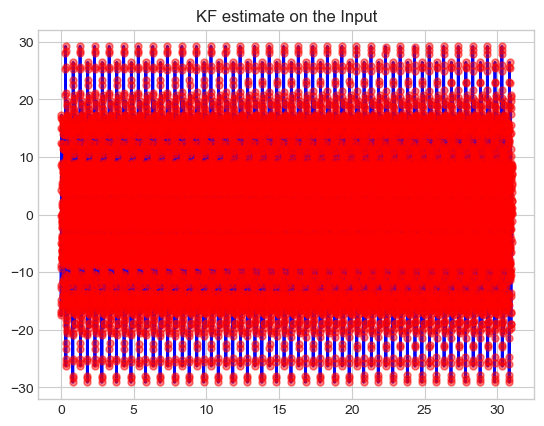

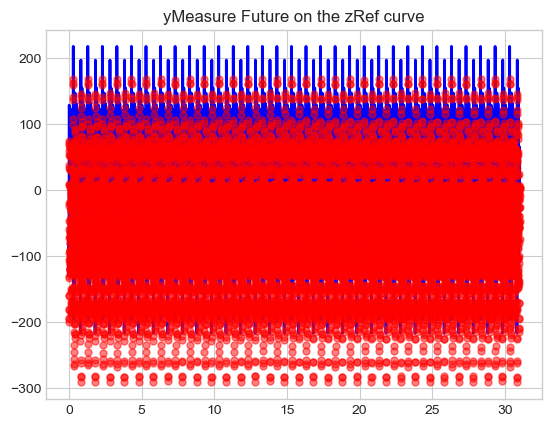

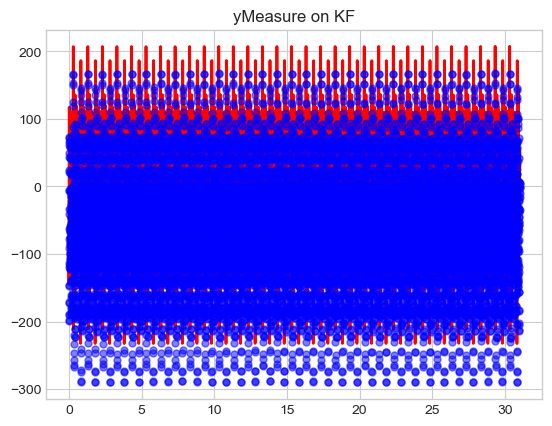

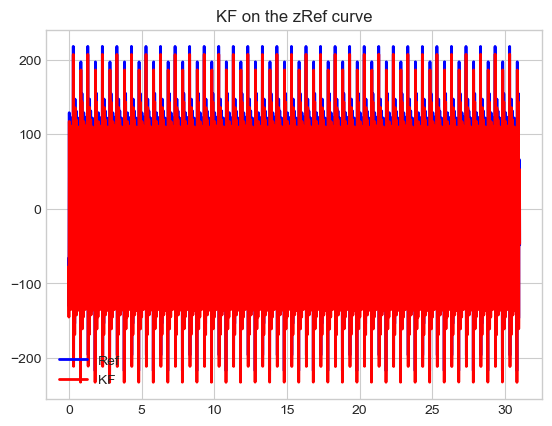

In [66]:
# plt.figure()
# plt.plot(timeRange, BInput, linestyle='-', linewidth=2, label='Ref', color='blue')
# plt.plot(timeRange[::2], KF_estimate_In[::2], 'o', markersize=5, linestyle='', label='Pred', alpha=0.5,color='red')
# plt.title('KF estimate on the Input curve')

plt.figure()
plt.plot(timeRange, BInput, linestyle='-', linewidth=2, label='Ref', color='blue')
plt.plot(timeRange[::2], KF_estimate_In[::2], 'o', markersize=5, linestyle='', label='Pred', alpha=0.5,color='red')
plt.title('KF estimate on the Input')


plt.figure()
plt.plot(timeRange, zRef, linestyle='-', linewidth=2, label='Ref', color='blue')
plt.plot(timeRange[::2], yMeasure[::2], 'o', markersize=5, linestyle='', label='Pred', alpha=0.5,color='red')
plt.title('yMeasure Future on the zRef curve')

plt.figure()
plt.plot(timeRange, KF_estimate_Measure, linestyle='-', linewidth=2, label='Ref', color='red')
plt.plot(timeRange[::2], yMeasureCurrent[::2], 'o', markersize=5, linestyle='', label='Pred', alpha=0.5,color='blue')
plt.title('yMeasure on KF')


plt.figure()
plt.plot(timeRange, zRef, linestyle='-', linewidth=2, label='Ref', color='blue')
#plt.plot(timeRange[::2], KF_estimate_Measure[::2], '0', markersize=5, linestyle='', label='Pred', alpha=0.5,color='red')
plt.plot(timeRange, KF_estimate_Measure, linestyle='-', linewidth=2, label='KF', color='red')
plt.legend()
plt.title('KF on the zRef curve')


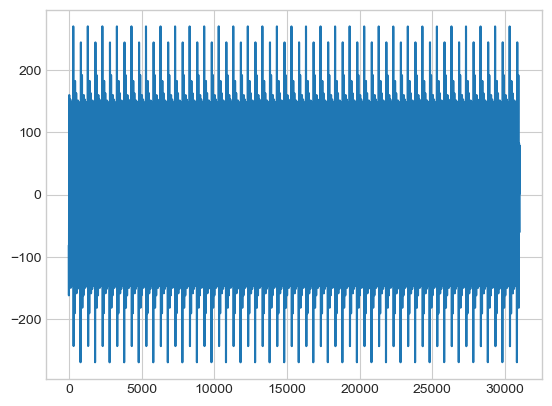

In [67]:
plt.plot(BInput*9.2393) # pT

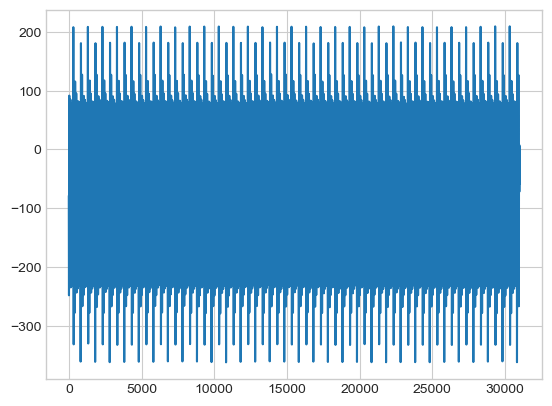

In [68]:
plt.plot(yMeasureCurrent/ 0.8072)

In [69]:
#np.savetxt('../result/ZRef_145C_v1.txt'.format(timeDelay), zRef)
np.savetxt('../result/yMeasure_delay{0}_startN{1}_145C_dampedSine.txt'.format(timeDelay,start_N), yMeasureCurrent)
np.savetxt('../result/KF_y_delay{0}_startN{1}_145C_dampedSine.txt'.format(timeDelay, start_N), KF_estimate_Measure)

Text(0.5, 1.0, 'KF err on yMeasure_Current')

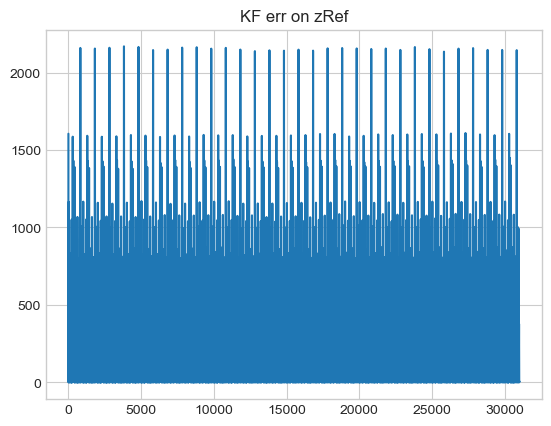

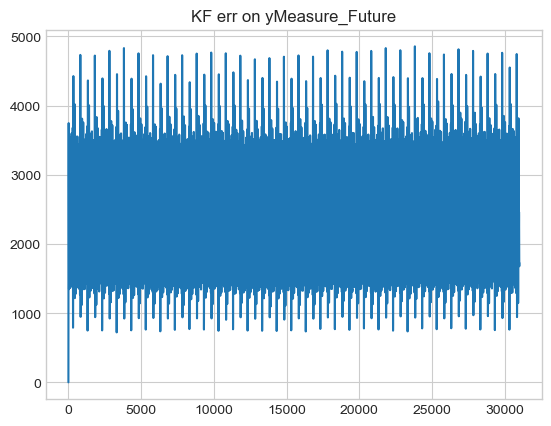

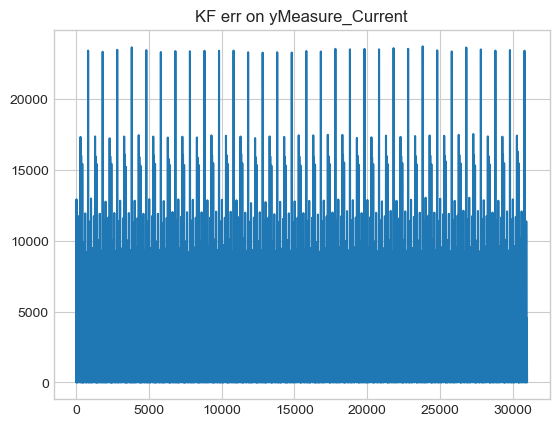

In [70]:
# 误差图绘制
Bin_err = KF_estimate_Measure - zRef
Measure_err = KF_estimate_Measure - yMeasure
Measure_err_Current = KF_estimate_Measure - yMeasureCurrent

plt.figure()
plt.plot(Bin_err**2)
plt.title('KF err on zRef')

plt.figure()
plt.plot(Measure_err**2)
plt.title('KF err on yMeasure_Future')


plt.figure()
plt.plot(Measure_err_Current**2)
plt.title('KF err on yMeasure_Current')

In [71]:
# import numpy as np
# import matplotlib.pyplot as plt

# start_num = 16
# measure_num = 100*50;
# store_list = np.asarray([zRef[start_num+i*50:start_num+i*50+50] for i in range(100)])
# print('Shape ', store_list.shape)

# def pointRange(pointList):
#     mean_point = np.mean(pointList)
#     #point_range = [mean_point - np.min(pointList), np.max(pointList) - mean_point]
#     point_range = 1*np.std(pointList)
#     return mean_point, point_range

# err_matrix = []
# y_locat = []

# for i in range(store_list.shape[1]):
#     mean_i, range_i = pointRange(store_list[:, i])
#     err_matrix.append(range_i)
#     y_locat.append(mean_i)

# err_matrix = np.asarray(err_matrix)    
# y_locat = np.asarray(y_locat)
# time_period = np.arange(0, 50)

# plt.errorbar(time_period, y_locat, yerr=err_matrix, fmt='o', color='r', ecolor='r', elinewidth=1, capsize=2, markersize=2, errorevery=1)

# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.title('zRef')

# plt.show()

# np.savetxt('../result/zRef_100epoch_mean.txt', y_locat)

In [72]:
# import numpy as np
# import matplotlib.pyplot as plt

# start_num = 16
# measure_num = 100*50;
# store_list = np.asarray([yMeasure[start_num+i*50:start_num+i*50+50] for i in range(100)])
# print('Shape ', store_list.shape)

# def pointRange(pointList):
#     mean_point = np.mean(pointList)
#     #point_range = [mean_point - np.min(pointList), np.max(pointList) - mean_point]
#     point_range = 1*np.std(pointList)
#     return mean_point, point_range

# err_matrix = []
# y_locat = []

# for i in range(store_list.shape[1]):
#     mean_i, range_i = pointRange(store_list[:, i])
#     err_matrix.append(range_i)
#     y_locat.append(mean_i)

# err_matrix = np.asarray(err_matrix)    
# y_locat = np.asarray(y_locat)
# time_period = np.arange(0, 50)

# plt.errorbar(time_period, y_locat, yerr=err_matrix, fmt='o', color='r', ecolor='r', elinewidth=1, capsize=2, markersize=2, errorevery=1)

# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.title('Data with error bars')

# plt.show()

# np.savetxt('../result/yMeasure_100epoch_mean.txt', y_locat)
# np.savetxt('../result/yMeasure_100epoch_std.txt', err_matrix)

Shape  (30, 1000)


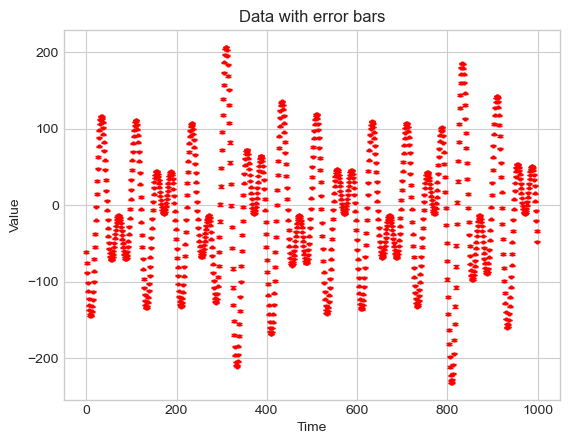

In [73]:
import numpy as np
import matplotlib.pyplot as plt

start_num = 1005
measure_num = start_num + 31000
store_list = np.asarray([KF_estimate_Measure[(i+1)*1000:(i+1)*1000+1000] for i in range(30)])
print('Shape ', store_list.shape)

def pointRange(pointList):
    mean_point = np.mean(pointList)
    #point_range = [mean_point - np.min(pointList), np.max(pointList) - mean_point]
    point_range = 1*np.std(pointList)
    return mean_point, point_range

err_matrix = []
y_locat = []

for i in range(store_list.shape[1]):
    mean_i, range_i = pointRange(store_list[:, i])
    err_matrix.append(range_i)
    y_locat.append(mean_i)

err_matrix = np.asarray(err_matrix)    
y_locat = np.asarray(y_locat)
time_period = np.arange(0, 1000)

plt.errorbar(time_period, y_locat, yerr=err_matrix, fmt='o', color='r', ecolor='r', elinewidth=1, capsize=2, markersize=2, errorevery=1)

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Data with error bars')

plt.show()
np.savetxt('../result/KF_known_100epoch_mean.txt', y_locat)
np.savetxt('../result/KF_known_100epoch_std.txt', err_matrix)

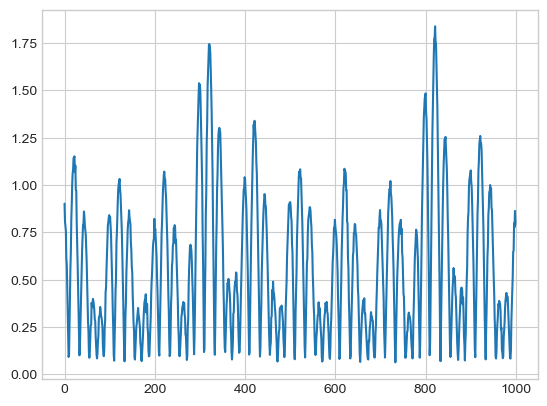

In [74]:
plt.plot(err_matrix)